## Parse the data

In [17]:
root = 'KMRLOpenData'

In [18]:
import os
os.listdir(root)


['stops.txt',
 'shapes.txt',
 'translations.txt',
 'trips.txt',
 'fare_rules.txt',
 'stop_times.txt',
 'feed_info.txt',
 'fare_attributes.txt',
 'calendar.txt',
 'routes.txt',
 'agency.txt']

In [19]:
import pandas as pd
df=pd.read_csv(root+'/stops.txt')
display(df.head(5))

,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1
3,ATTK,10.0793,76.3389,Ambattukavu,NaN,0,ATTK,1
4,MUTT,10.0727,76.3336,Muttom,NaN,0,MUTT,1


## Create the geometry layer

In [20]:
from shapely.geometry import Point

In [21]:
import geopandas as gpd

In [22]:
geometry= [Point(xy) for xy in zip (df['stop_lon'], df['stop_lat'])]
geometry[0:5]

[<POINT (76.35 10.11)>,
 <POINT (76.347 10.095)>,
 <POINT (76.343 10.087)>,
 <POINT (76.339 10.079)>,
 <POINT (76.334 10.073)>]

In [23]:
gdf=df.copy()
gdf['geometry']=geometry
type(gdf)

pandas.core.frame.DataFrame

In [24]:
gdf=gpd.GeoDataFrame(gdf)
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [25]:
gdf.head(5)

,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding,geometry
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1,POINT (76.3495 10.1099)
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1,POINT (76.3466 10.0951)
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1,POINT (76.3428 10.0873)
3,ATTK,10.0793,76.3389,Ambattukavu,NaN,0,ATTK,1,POINT (76.3389 10.0793)
4,MUTT,10.0727,76.3336,Muttom,NaN,0,MUTT,1,POINT (76.3336 10.0727)


<Axes: >

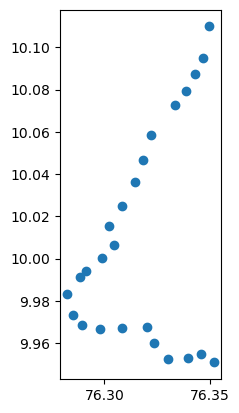

In [26]:
gdf.plot()

(np.float64(76.2788235),
 np.float64(76.35530650000001),
 np.float64(9.942824),
 np.float64(10.117856))

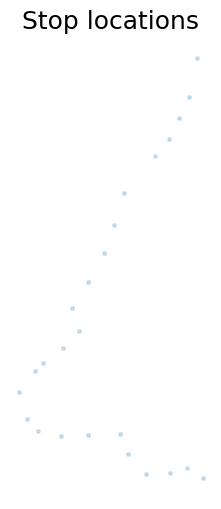

In [27]:
import matplotlib.pyplot as plt
f,ax=plt.subplots(1,1, figsize=(6,6))
ax.set_title('Stop locations',fontsize=18)
gdf.plot(ax=ax, alpha=0.2, markersize=6)
ax.axis('off')

In [28]:
# ============================================================
# STEP 1: Load GTFS Data & Explore
# Kochi Metro (KMRL) Last-Mile & Service Risk Analysis
# ============================================================

import pandas as pd
import os

root = 'KMRLOpenData'

# --- Load all relevant GTFS files ---
stops      = pd.read_csv(f'{root}/stops.txt')
routes     = pd.read_csv(f'{root}/routes.txt')
trips      = pd.read_csv(f'{root}/trips.txt')
stop_times = pd.read_csv(f'{root}/stop_times.txt')
calendar   = pd.read_csv(f'{root}/calendar.txt')

print("=== STOPS ===")
print(stops.shape)
display(stops.head(3))

print("\n=== ROUTES ===")
print(routes.shape)
display(routes.head(3))

print("\n=== TRIPS ===")
print(trips.shape)
display(trips.head(3))

print("\n=== STOP_TIMES ===")
print(stop_times.shape)
display(stop_times.head(3))

print("\n=== CALENDAR ===")
display(calendar)

=== STOPS ===
(25, 8)


,stop_id,stop_lat,stop_lon,stop_name,stop_desc,location_type,zone_id,wheelchair_boarding
0,ALVA,10.1099,76.3495,Aluva,NaN,0,ALVA,1
1,PNCU,10.0951,76.3466,Pulinchodu,NaN,0,PNCU,1
2,CPPY,10.0873,76.3428,Companypady,NaN,0,CPPY,1



=== ROUTES ===
(1, 5)


,route_id,route_short_name,route_long_name,route_type,agency_id
0,R1,KMRL,Kochi Metro Route 1,1,KMRL



=== TRIPS ===
(450, 5)


,route_id,service_id,trip_id,direction_id,shape_id
0,R1,WK,WK_1,0,R1_0
1,R1,WK,WK_2,1,R1_1
2,R1,WK,WK_22,0,R1_0



=== STOP_TIMES ===
(10726, 7)


,trip_id,stop_sequence,stop_id,arrival_time,departure_time,timepoint,shape_dist_traveled
0,WE_1,1,TPHT,22:50:19,22:52:41,1,0.00
1,WE_1,2,SNJN,22:54:30,22:54:45,1,0.99
2,WE_1,3,VAKK,22:56:08,22:56:23,1,1.72



=== CALENDAR ===


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,WK,1,1,1,1,1,1,0,20240812,20251231
1,WE,0,0,0,0,0,0,1,20240812,20251231
